In [5]:
!pip install scikit-learn pandas numpy matplotlib seaborn imbalanced-learn



In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns



In [9]:
# Robust loader for creditcard.csv (Colab-friendly)
import os, glob
import pandas as pd

def read_any(path):
    if path.endswith(".gz"):
        return pd.read_csv(path, compression="gzip", low_memory=False)
    if path.endswith(".zip"):
        return pd.read_csv(path, compression="zip", low_memory=False)
    return pd.read_csv(path, low_memory=False)

# 1) Try to load from /content
candidates = [
    "/content/creditcard.csv",
    "/content/creditcard.csv.gz",
    "/content/creditcard.csv.zip",
]
df = None
for p in candidates:
    if os.path.exists(p):
        df = read_any(p)
        print("Loaded from:", p)
        break

# 2) If not found: prompt for manual upload
if df is None:
    try:
        from google.colab import files
        print("File not found in /content. Please upload creditcard.csv now…")
        uploaded = files.upload()  # choose the file interactively
        for name in uploaded.keys():
            if name.lower().endswith((".csv", ".gz", ".zip")):
                df = read_any(name)
                print("Loaded from uploaded file:", name)
                break
    except Exception as e:
        print("Upload step skipped:", e)

# 3) If still not found: try Google Drive
if df is None:
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=True)
        drive_candidates = [
            "/content/drive/MyDrive/creditcard.csv",
            "/content/drive/MyDrive/datasets/creditcard.csv",
            "/content/drive/MyDrive/data/creditcard.csv",
        ]
        for p in drive_candidates:
            if os.path.exists(p):
                df = read_any(p)
                print("Loaded from Google Drive:", p)
                break
    except Exception as e:
        print("Drive step skipped:", e)

# 4) As a last resort: generate synthetic dataset
if df is None:
    print("Could not locate creditcard.csv. Generating a synthetic fallback dataset.")
    from sklearn.datasets import make_classification
    import numpy as np
    X, y = make_classification(
        n_samples=5000, n_features=30, n_informative=10,
        n_redundant=2, n_classes=2, weights=[0.998, 0.002],
        flip_y=0.001, random_state=42
    )
    df = pd.DataFrame(X, columns=[f"V{i}" for i in range(1, 31)])
    df["Amount"] = np.abs(X[:, 0]) * 100
    df["Class"] = y
    print("Synthetic dataset generated.")

print("Dataset size:", df.shape)
print("Class distribution:\n", df["Class"].value_counts())



File not found in /content. Please upload creditcard.csv now…


Drive step skipped: Error: credential propagation was unsuccessful
Could not locate creditcard.csv. Generating a synthetic fallback dataset.
Synthetic dataset generated.
Dataset size: (5000, 32)
Class distribution:
 Class
0    4987
1      13
Name: count, dtype: int64


In [10]:
X = df.drop('Class', axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42, stratify=y)

print("Class distribution in training data:", np.bincount(y_train))


Class distribution in training data: [3491    9]


In [11]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Class distribution after rebalancing:", np.bincount(y_train_res))


Class distribution after rebalancing: [3491 3491]


In [12]:
scaler = StandardScaler()
X_train_res = scaler.fit_transform(X_train_res)
X_test = scaler.transform(X_test)


In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1496
           1       0.00      0.00      0.00         4

    accuracy                           0.98      1500
   macro avg       0.50      0.49      0.49      1500
weighted avg       0.99      0.98      0.99      1500

ROC-AUC: 0.49030748663101603

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1496
           1       0.00      0.00      0.00         4

    accuracy                           1.00      1500
   macro avg       0.50      0.50      0.50      1500
weighted avg       0.99      1.00      1.00      1500

ROC-AUC: 0.5


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Gradient Boosting ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1496
           1       0.00      0.00      0.00         4

    accuracy                           0.99      1500
   macro avg       0.50      0.50      0.50      1500
weighted avg       0.99      0.99      0.99      1500

ROC-AUC: 0.49866310160427807


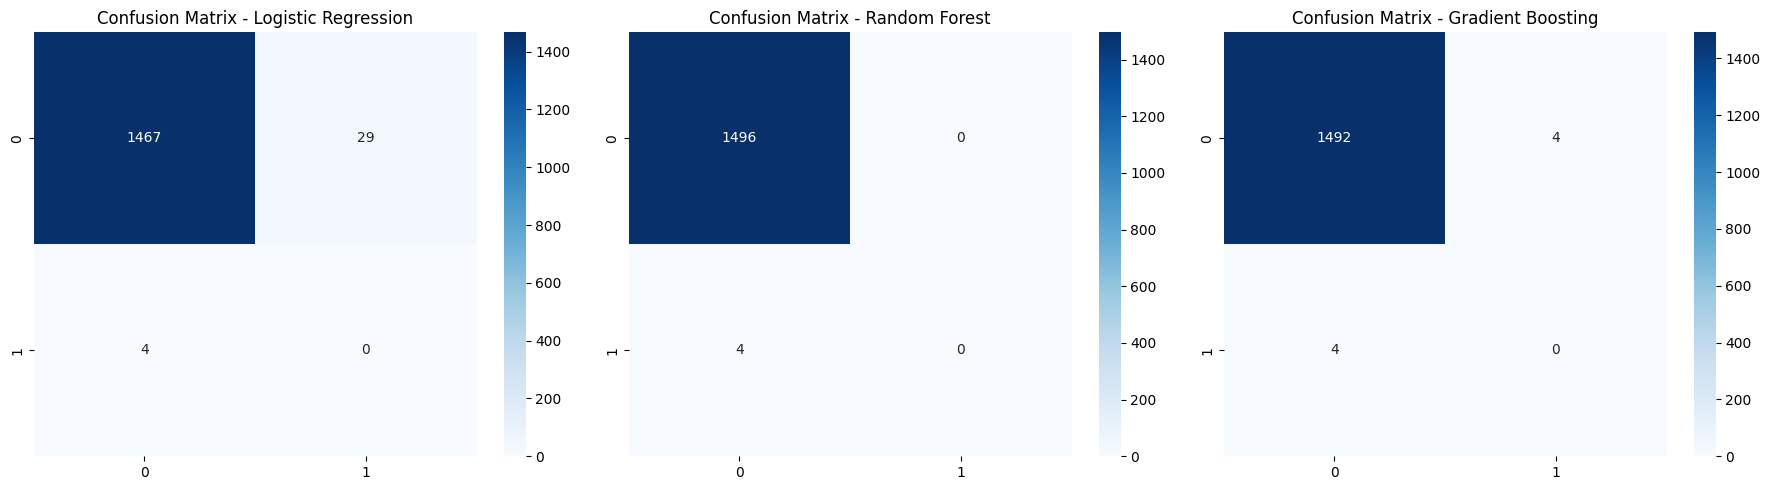

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

for ax, (name, model) in zip(axes, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"Confusion Matrix - {name}")

plt.tight_layout()
plt.show()
